In [1]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
import matplotlib.pyplot as plt

In [2]:
train_path = '../chest_xray/train'
test_path = '../chest_xray/test'
val_path = '../chest_xray/val'

train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,
    zoom_range=0.3
)

train_ds = train_generator.flow_from_directory(
    train_path,
    target_size=(256,256),
    class_mode='binary',
)

Found 4175 images belonging to 2 classes.


In [3]:
val_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_ds = val_generator.flow_from_directory(
    val_path,
    target_size=(256,256),
    class_mode='binary',
)

Found 1057 images belonging to 2 classes.


In [4]:
test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_ds = test_generator.flow_from_directory(
    test_path,
    target_size=(256,256),
    class_mode='binary'
)

Found 624 images belonging to 2 classes.


In [5]:
vgg_base = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False
)

vgg_base.trainable = False

In [6]:
model = models.Sequential()

model.add(vgg_base)                   
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

for layer in model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten True
dense True
dense_1 True
dense_2 True
dense_3 True
dense_4 True


In [7]:
checkpoint = keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/11_vgg_decay.hdf5',
    save_best_only=True,
    verbose=0
)

callbacks = [checkpoint]

In [8]:
use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

scheduler = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_rate=0.96,
    decay_steps=2500
)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=scheduler),
    metrics=[use_metrics]
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

model = keras.models.load_model('save_data/11_vgg_decay.hdf5')

Epoch 1/20
131/131 [==============================] - 185s 1s/step - loss: 1.5442 - binary_accuracy: 0.8537 - precision: 0.9003 - recall: 0.9029 - val_loss: 0.1844 - val_binary_accuracy: 0.9290 - val_precision: 0.9876 - val_recall: 0.9157
Epoch 2/20
131/131 [==============================] - 184s 1s/step - loss: 0.1968 - binary_accuracy: 0.9178 - precision: 0.9483 - recall: 0.9406 - val_loss: 0.2631 - val_binary_accuracy: 0.8553 - val_precision: 0.9968 - val_recall: 0.8072
Epoch 3/20
131/131 [==============================] - 186s 1s/step - loss: 0.1715 - binary_accuracy: 0.9356 - precision: 0.9582 - recall: 0.9548 - val_loss: 0.1803 - val_binary_accuracy: 0.9470 - val_precision: 0.9919 - val_recall: 0.9361
Epoch 4/20
131/131 [==============================] - 186s 1s/step - loss: 0.1578 - binary_accuracy: 0.9425 - precision: 0.9575 - recall: 0.9655 - val_loss: 0.1294 - val_binary_accuracy: 0.9480 - val_precision: 0.9879 - val_recall: 0.9413
Epoch 5/20
131/131 [========================

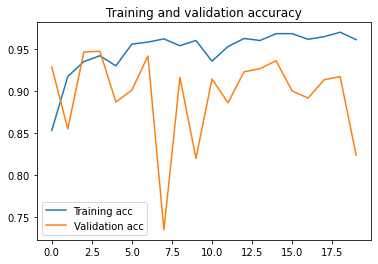

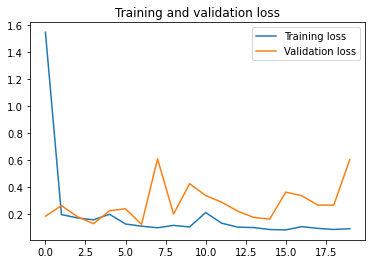

In [10]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [11]:
train_res = model.evaluate(train_ds)

131/131 [==============================] - 144s 1s/step - loss: 0.1503 - binary_accuracy: 0.9473 - precision: 0.9393 - recall: 0.9932


In [12]:
val_res = model.evaluate(val_ds)

34/34 [==============================] - 36s 1s/step - loss: 0.1240 - binary_accuracy: 0.9423 - precision: 0.9972 - recall: 0.9246


In [13]:
test_res = model.evaluate(test_ds)

20/20 [==============================] - 21s 1s/step - loss: 0.3143 - binary_accuracy: 0.9054 - precision: 0.8753 - recall: 0.9897
